In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import wave, struct
from copy import deepcopy
from weighted_levenshtein import lev

from scipy.io import wavfile


from Classifier.load_data import load_training_data

from Classifier.plot_data import plot_labelled_wave, plot_predictions, plot_detection_errors

from Classifier.classifier import (streaming_classifier,
                                   three_pronged_smoothing_classifier,
                                   one_pronged_smoothing_classifier,
                                   zeroes_classifier,
                                   catch22_knn_classifier)


In [2]:

waves, labels, samprate = load_training_data(path = "/Users/darap/Documents/School/University/2021, Sem. 1/DATA3888/Aqua10/Datasets/Good Data - Sandeep no errors/",
                       scale_factor= 512/(2**13 - 1),
                       blacklist = ["blink", "different", "fast", "slow", "eyebrow", "left-right-middle-sandeep", "left-right-middle-marina"])


dict_keys(['left-middle-right-middle#2', 'left-middle-right-middle', 'left-middle-right-steph', 'left-middle-right-steph2', 'left-middle', 'right-middle']) dict_keys(['left-middle-right-middle#2', 'left-middle-right-middle', 'left-middle-right-steph', 'left-middle-right-steph2', 'left-middle', 'right-middle'])
c:\Users\darap\Documents\School\University\2021, Sem. 1\DATA3888\Aqua10\Classifier\load_data.py:68: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)


In [4]:
# Set parameters such that event detection window lands in the middle of the signal

hyp_event_smart_threshold_window = 5
hyp_event_smart_threshold_factor = 5

hyp_detection_buffer_end = 1/samprate
hyp_detection_buffer_start = 0


det_window = 0.6432

window_size = det_window + hyp_detection_buffer_end + hyp_detection_buffer_start

N_loops_over_window = 15

buffer_size = window_size/N_loops_over_window

hyp_consecutive_triggers = int(np.ceil(det_window/buffer_size))
print(hyp_consecutive_triggers)




# fig, ax = plt.subplots(len(waves), 1)
# fig.set_size_inches(15, 3*len(waves))



classifiers = {"One-pronged": one_pronged_smoothing_classifier,
               "Three-pronged": three_pronged_smoothing_classifier,
               "Zeros classifier": zeroes_classifier,
               "KNN classifier": catch22_knn_classifier}

open("classifier_optimisation.csv", 'w').close()    # Clears the file so that the code can be run again.

for classifier_label, classifier in classifiers.items():
    print(classifier_label)
    for w in np.linspace(0, 2-det_window, 100):
        hyp_detection_buffer_end = max(w/2, 1/samprate)
        hyp_detection_buffer_start = w/2
        window_size = det_window + hyp_detection_buffer_end + hyp_detection_buffer_start

        buffer_size = window_size/N_loops_over_window
        hyp_consecutive_triggers = int(np.ceil(det_window/buffer_size))



        for i, key in enumerate(waves):


            predictions, predictions_timestamps, predictions_storage = streaming_classifier(
                waves[key], # Either the array from file (or ser if live = True)
                samprate,
                classifier = classifier, 
                window_size = window_size, # Total detection window [s]
                N_loops_over_window = N_loops_over_window, # implicitly defines buffer to be 1/x of the window
                hyp_detection_buffer_end = hyp_detection_buffer_end, # seconds - how much time to shave off end of the window in order to define the middle portion
                hyp_detection_buffer_start = hyp_detection_buffer_start, # seconds - how much time to shave off start of the window in order to define the middle portion
                hyp_event_smart_threshold_window = hyp_event_smart_threshold_window, # The length of the calibration period to define the threshold
                hyp_calibration_statistic_function = np.std, # Function that calculates the calibration statistic
                hyp_test_statistic_function = lambda x: np.max(x) - np.min(x), # Function that calculates the test statistic
                hyp_event_smart_threshold_factor = hyp_event_smart_threshold_factor, # The scale factor of the calibration range that will become the threshold
                hyp_event_history = hyp_consecutive_triggers+1, # How many historical event detection results are kept in memory (whether the test criteria failed or passed)
                hyp_consecutive_triggers = hyp_consecutive_triggers, # How many threshold triggers need to occur in a row for an event to be called
                hyp_consecutive_reset = 1, # How many threshold failures need to occur in a row for the classifier to be primed for a new event
                total_time = None,  # max time. If none, it goes forever!
                plot = False, # Whether to plot the livestream data
                store_events = True, # Whether to return the classification window array for debugging purposes
                verbose=False, # lol
                live = False, # Whether we're live
                hyp_timeout = 10,
                timeout = False)

            actuals = "".join(labels[key].label)

            lev_dist = lev(actuals, predictions)
            acc = abs(len(actuals) - lev_dist)/len(actuals)
            
            with open("classifier_optimisation.csv", "a") as file:
                file.write(",".join([classifier_label, str(window_size), key, predictions, actuals, str(lev_dist), str(acc)]) + '\n')
            print("done")


    
    
#     plot_predictions(waves[key], samprate, labels[key], predictions, predictions_timestamps, ax, i,
#                      title="", before_buffer = 0.7, after_buffer = 1, actual_alpha=0.0,
#                      wave_alpha=1, pred_alpha = 0.5, miny = -100, maxy = 100)



15
One-pronged
done
done
done
done
done
done
done
done


KeyboardInterrupt: 

In [5]:
results = pd.read_csv("classifier_optimisation.csv", header=None)

results.columns = ["classifier", "window_size", "file", "predicted", "actual", "lev_dist", "accuracy"]

results_agg = results.groupby(["window_size", "classifier"]).mean()
results_agg.reset_index(inplace=True)
results_agg

,window_size,classifier,lev_dist,accuracy
0,0.643300,KNN classifier,6.833333,0.594631
1,0.643300,One-pronged,7.000000,0.539252
2,0.643300,Three-pronged,17.500000,0.011905
3,0.643300,Zeros classifier,4.000000,0.789567
4,0.656905,KNN classifier,6.166667,0.630705
...,...,...,...,...
395,1.986295,Zeros classifier,3.000000,0.842103
396,2.000000,KNN classifier,4.833333,0.720809
397,2.000000,One-pronged,7.833333,0.482308
398,2.000000,Three-pronged,2.500000,0.878986


Text(0.5, 1.0, 'Classifier Accuracy vs. Window Size')

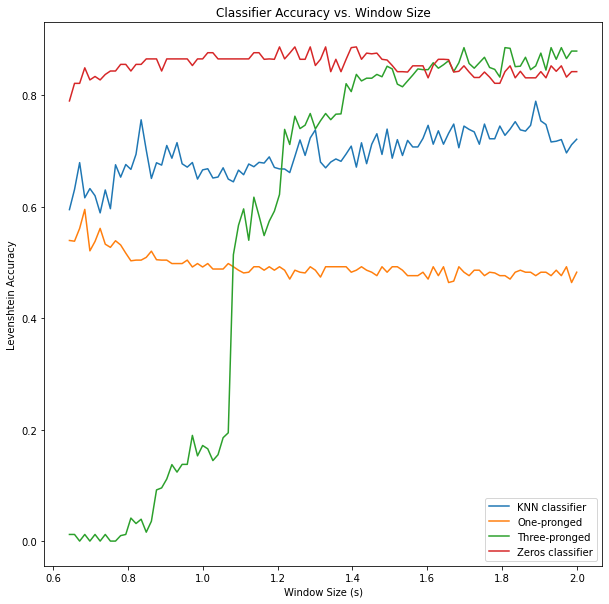

In [6]:
plt.figure(figsize=(10, 10))

for classifier in results_agg.classifier.unique():
    filt = results_agg.classifier == classifier
    plt.plot(results_agg[filt].window_size, results_agg[filt].accuracy, label=classifier)

plt.legend()
plt.ylabel("Levenshtein Accuracy")
plt.xlabel("Window Size (s)")
plt.title("Classifier Accuracy vs. Window Size")

    
    